# Classify using convolutional neural network (CNN)

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Flatten
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler

import numpy as np
from os.path import join
from sklearn.model_selection import train_test_split
import pickle

2025-01-16 13:36:43.758321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 13:36:43.765991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737031003.774931   91219 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737031003.777604   91219 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 13:36:43.789017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 7

# size of sample used to train the model
NUM_SAMPLES = 10000

# Rescale the data (color) values
scale = False  # rather not

Load the data prepared in previous notebook

In [4]:
with np.load(join(DATA_PATH, 'train_data.npz')) as data:
    data_dict=dict(data.items())
X_train = data_dict['X']
y_train = data_dict['y']

Optionally subsample the data for faster training during try-outs

In [5]:
import random

# Get a smaller random sample 
idx = random.sample(range(len(X_train)-1), NUM_SAMPLES)
X_train_sub = X_train[idx]
y_train_sub = y_train[idx]

In [6]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(output_classes, activation='softmax'))

/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-16 13:36:58.851184: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Define the model

In [7]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Define loss function, optimizer, and metrics to track during training
model.compile(
    optimizer='adam', # .. or optimizers.SGD(lr=0.01)
    loss='sparse_categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['acc'] # .. or metrics.sparse_categorical_accuracy
)


Optionally rescale the data, one-hot encode the labels

In [8]:
if scale:
    # Rescale train and validation data
    scaler = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train_sub.reshape([-1, input_dim])).reshape([-1, input_width, input_height, input_depth])
else:
    X_train_preprocessed = X_train_sub

classes, y_train_preprocessed = np.unique(y_train_sub, return_inverse=True)

print('Train:', X_train_preprocessed.shape)


Train: (10000, 300, 300, 3)


Display some images as a check

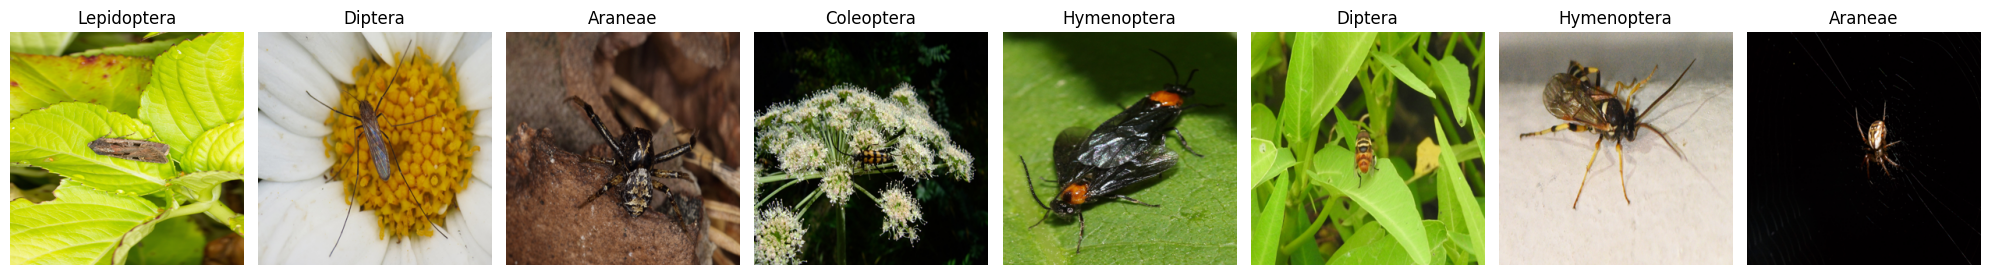

In [9]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

check_images = 8
idx = random.sample(range(len(X_train_preprocessed)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X_train_preprocessed[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    ax[i].set_title(classes[y_train_preprocessed[id]])
    ax[i].axis('off')
plt.tight_layout()
plt.show();

In [10]:
%%time
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train_preprocessed,
    validation_split=0.2, batch_size=32, epochs=20,
    shuffle=True # Shuffle training samples
)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 628s 3s/step - acc: 0.1461 - loss: 5801.4346 - val_acc: 0.1510 - val_loss: 1.9452
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - acc: 0.1546 - loss: 1.9446 - val_acc: 0.1580 - val_loss: 1.9448
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - acc: 0.1653 - loss: 1.9432 - val_acc: 0.1580 - val_loss: 1.9448
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - acc: 0.1600 - loss: 1.9435 - val_acc: 0.1580 - val_loss: 1.9448
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - acc: 0.1586 - loss: 1.9440 - val_acc: 0.1580 - val_loss: 1.9449
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - acc: 0.1612 - loss: 1.9431 - val_acc: 0.1580 - val_loss: 1.9451
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - acc: 0.1604 - loss: 1.9437 - val_acc: 0.1580 - val_loss: 1.9451
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - acc: 0.1633 - loss: 1.9427 - val_acc: 0.1580 - val_loss: 1.9451
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 612s 

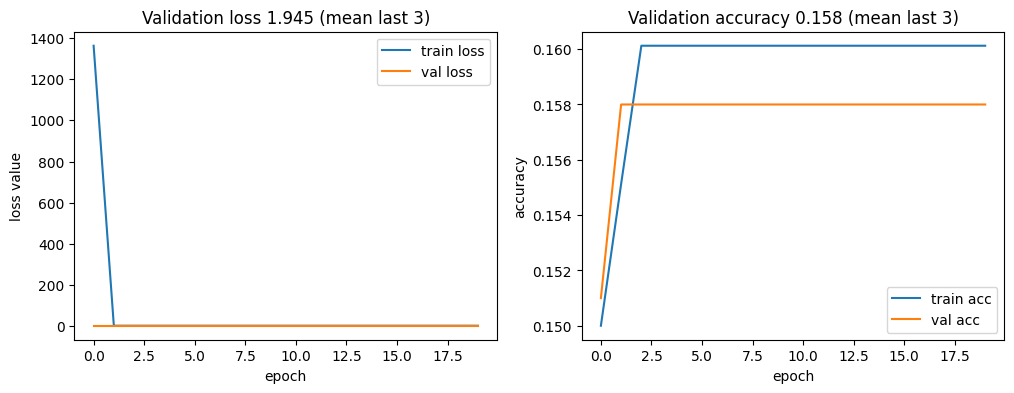

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()


## Save the model

In [12]:
with open(join(MODELS_PATH, 'cnn.pickle'), 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)